In [1]:
import os
from tqdm import tqdm
import tensorflow_datasets as tfds
import tensorflow as tf

/home/yixiuz/miniconda3/envs/maskgit_jax/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-09-19 03:37:12.163592: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-19 03:37:12.206036: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-19 03:37:12.219085: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-19 03:37:12.247735: I tensorflow/core/platform/cpu_feature_guard.cc:210] This Tenso

In [2]:
%cd ~
import jax
import fidjax
jax.devices()

/home/yixiuz


[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

In [2]:
manual_dir = '/dev/shm/'
data_dir = '/mnt/disks/persist/'

tfds.disable_progress_bar()
# Create a DownloadConfig with the manual_dir specified
download_config = tfds.download.DownloadConfig(manual_dir=manual_dir)
(train_dataset, val_dataset), dataset_info = tfds.load(
    'imagenet2012',
    split=['train', 'validation'],
    data_dir=data_dir,
    download_and_prepare_kwargs={'download_config': download_config},
    with_info=True,
)

In [33]:
def resize(image, image_size):
    return tf.image.resize(
            [image], [image_size, image_size], method=tf.image.ResizeMethod.BICUBIC
    )[0]

def normalize(image):
    return tf.cast(image, tf.float32) / 255.0

def center_crop_largest(image):
    h = tf.shape(image)[0]
    w = tf.shape(image)[1]
    
    if (h > w):
        short_edge = w
    else:
        short_edge = h
    # Center crop
    crop_y = (h - short_edge) // 2
    crop_x = (w - short_edge) // 2
    cropped_image = image[crop_y:crop_y+short_edge, crop_x:crop_x+short_edge]
    return cropped_image

def preprocess_data(i):
    image = i["image"]

    image = normalize(image)
    image = center_crop_largest(image)
    image = resize(image, 256)

    image = tf.clip_by_value(image, 0, 1)
    
    return image

processed = train_dataset.map(preprocess_data)

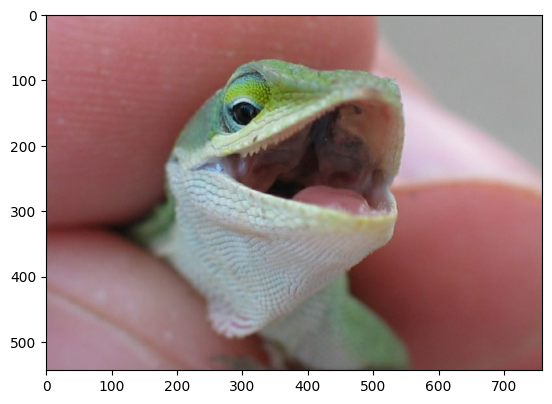

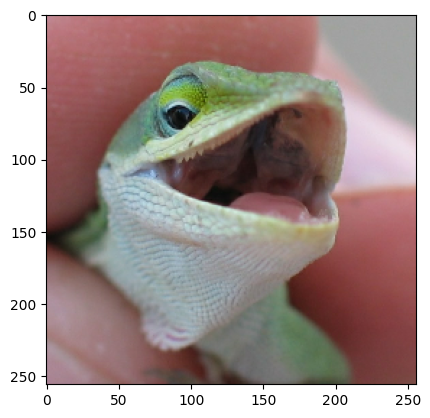

In [34]:
import matplotlib.pyplot as plt
id = 1
plt.imshow(list(train_dataset.take(1000))[id]["image"].numpy())
plt.figure()
plt.imshow(list(processed.take(1000))[id].numpy())

In [37]:
# Saving 10K samples into a folder
import os
from PIL import Image
import numpy as np

# Define the output folder for saving the images
output_folder = 'imagenet_10k'
os.makedirs(output_folder, exist_ok=True)

# Shuffle and take 10,000 random samples
num_images = 10_000
random_images = processed.shuffle(1024).take(num_images)

# Function to convert a TensorFlow image to PIL and save it
def save_image(image_tensor, image_index):
    # Convert the image from a TensorFlow tensor to a numpy array
    image_np = (image_tensor * 255).numpy().astype(np.uint8)

    # Convert to PIL Image and save
    pil_image = Image.fromarray(image_np)
    pil_image.save(os.path.join(output_folder, f'image_{image_index}.png'))

# Iterate through the dataset and save the images
for index, sample in enumerate(random_images):
    # Extract the image tensor (and preprocess if necessary)
    image = sample 
        
    # Save the processed image
    save_image(image, index)

    if index >= num_images - 1:
        break

print(f"Saved {num_images} images to {output_folder}")


Saved 10000 images to imagenet_10k


# Compute FID

In [9]:
from PIL import Image

import fidjax
import numpy as np
from jax import numpy as jnp
from tqdm import trange

weights = '/home/yixiuz/inception_v3_weights_fid.pickle?dl=1'
reference = '/home/yixiuz/VIRTUAL_imagenet256_labeled.npz'
fid = fidjax.FID(weights, reference)

fid_total = 10000
fid_batch = 1000
acts = []

# image_dir = "/home/yixiuz/model_samples/test_samples_10k_clipped/home/yixiuz/logs/samples/" # I messed up the tar command lol
image_dir = "/home/yixiuz/imagenet_10k/"

imgs = []
img_id = 0
for i in range(fid_total // fid_batch):
    jax_images = []

    print(img_id)
    # Loop through image IDs from 1 to 10,000
    for _ in trange(1000):
        img_id += 1
        img_path = os.path.join(image_dir, f"image_{img_id}.png")
    
        # Check if the image file exists
        if os.path.exists(img_path):
            # Open and load the image using Pillow
            img = Image.open(img_path)
            # Convert the image to a NumPy array
            img_np = jnp.array(img)
            jax_images.append(img_np)
    
    samples = jnp.stack(jax_images)
    acts.append(fid.compute_acts(samples))

ref_stats = fid.compute_stats(acts)

# score = fid.compute_score(stats)
# print(float(score))  # FID

0


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 231.99it/s]


1000


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 205.41it/s]


2000


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 204.25it/s]


3000


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 203.67it/s]


4000


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 203.48it/s]


5000


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 204.18it/s]


6000


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 203.30it/s]


7000


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 203.01it/s]


8000


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 203.78it/s]


9000


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 203.40it/s]


In [10]:
def compute_score(stats, ref):
    mu1, sigma1 = stats
    mu2, sigma2 = ref
    diff = mu1 - mu2
    offset = jnp.eye(sigma1.shape[0]) * 1e-6
    covmean = jax.scipy.linalg.sqrtm((sigma1 + offset) @ (sigma2 + offset))
    covmean = jnp.real(covmean)
    fid = diff @ diff + jnp.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

stats_cpu = jax.device_put(stats, device=jax.devices("cpu")[0])
# ref_cpu = jax.device_put(fid.ref, device=jax.devices("cpu")[0])
ref_cpu = jax.device_put(ref_stats, device=jax.devices("cpu")[0])
score = compute_score(stats_cpu, ref_cpu)
# Consistent
print(score)

68.609116


In [11]:
64.98761

64.98761

# Convert processed images to codes

In [192]:
%cd maskgit-jax

/home/yixiuz/maskgit-jax


In [195]:
%cd maskgit

/home/yixiuz/maskgit-jax/maskgit


In [193]:
import maskgit
from maskgit.utils import visualize_images, read_image_from_url, restore_from_path, draw_image_with_bbox, Bbox
from maskgit.inference import ImageNet_class_conditional_generator

In [196]:
model = ImageNet_class_conditional_generator(image_size=256)

In [209]:
# def _create_input_batch(self, image):
#         return np.repeat(image[None], self.maskgit_cf.eval_batch_size, axis=0).astype(np.float32)

# imgs = list(processed.take(1))[0].numpy()[None]

def apply_tokenizer(imgs):
    image_tokens = model.tokenizer_model.apply(
              model.tokenizer_variables,
              {"image": imgs},
              method=model.tokenizer_model.encode_to_indices,
              mutable=False)
    return image_tokens

def tfds_to_numpy(dataset, batch_size):
    def _generator():
        for image in dataset.batch(batch_size):
            yield image.numpy()
    return _generator

In [235]:
print(len(processed))
tqdm._instances.clear()

1281167


In [232]:
# Parallelize the apply_model function
parallel_apply_tokenizer = jax.pmap(apply_tokenizer)

# Set the batch size
batch_size = 128 * 4
code_size = 16
device_count = jax.local_device_count()

# Convert the dataset to NumPy arrays
train_gen = tfds_to_numpy(processed, batch_size)

# Collect the output
train_outputs = []
for batch_images in tqdm(train_gen(), total=len(processed) // batch_size):
    # Apply the parallelized model
    output = parallel_apply_tokenizer(batch_images.reshape((device_count, batch_size // device_count) + batch_images.shape[1:]))
    train_outputs.append(output.reshape((batch_size, 16, 16)))

# Optionally, concatenate the outputs
train_outputs = jnp.concatenate(train_outputs, axis=0)

print(train_outputs.shape)  # Output shape

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 2502/2502 [09:52<00:00,  4.22it/s]


ValueError: cannot reshape array of size 28114944 into shape (4,128,256,256,3)

In [234]:
train_outputs = jnp.concatenate(train_outputs, axis=0)

print(train_outputs.shape)  # O

(1281024, 16, 16)


In [237]:
jnp.save("vq_tokens_256x256.npy", train_outputs, allow_pickle=True)

In [239]:
imgs = model.tokenizer_model.apply(
              model.tokenizer_variables,
              train_outputs[:10],
              method=model.tokenizer_model.decode_from_indices)

In [240]:
imgs.shape

(10, 256, 256, 3)

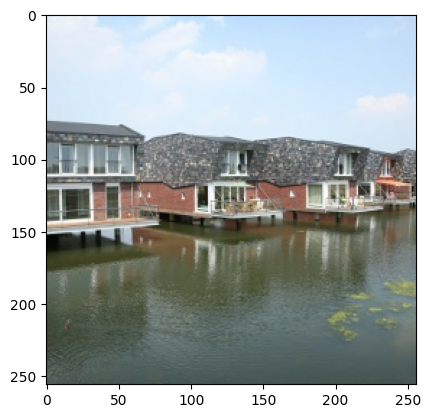

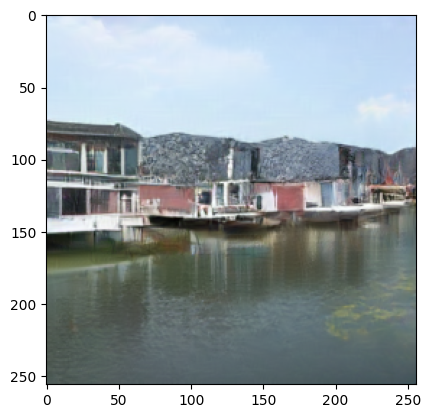

In [249]:
id = 4
plt.imshow(list(processed.take(1000))[id].numpy())
plt.figure()
plt.imshow(imgs[id])

# Scratch

In [56]:
"""ImageNet input pipeline."""

import jax
import tensorflow as tf
import tensorflow_datasets as tfds


IMAGE_SIZE = 224
CROP_PADDING = 32
MEAN_RGB = [0.485 * 255, 0.456 * 255, 0.406 * 255]
STDDEV_RGB = [0.229 * 255, 0.224 * 255, 0.225 * 255]


def distorted_bounding_box_crop(
        image_bytes,
        bbox,
        min_object_covered=0.1,
        aspect_ratio_range=(0.75, 1.33),
        area_range=(0.05, 1.0),
        max_attempts=100,
):
    """Generates cropped_image using one of the bboxes randomly distorted.

    See `tf.image.sample_distorted_bounding_box` for more documentation.

    Args:
        image_bytes: `Tensor` of binary image data.
        bbox: `Tensor` of bounding boxes arranged `[1, num_boxes, coords]`
                where each coordinate is [0, 1) and the coordinates are arranged
                as `[ymin, xmin, ymax, xmax]`. If num_boxes is 0 then use the whole
                image.
        min_object_covered: An optional `float`. Defaults to `0.1`. The cropped
                area of the image must contain at least this fraction of any bounding
                box supplied.
        aspect_ratio_range: An optional list of `float`s. The cropped area of the
                image must have an aspect ratio = width / height within this range.
        area_range: An optional list of `float`s. The cropped area of the image
                must contain a fraction of the supplied image within this range.
        max_attempts: An optional `int`. Number of attempts at generating a cropped
                region of the image of the specified constraints. After `max_attempts`
                failures, return the entire image.
    Returns:
        cropped image `Tensor`
    """
    shape = tf.io.extract_jpeg_shape(image_bytes)
    sample_distorted_bounding_box = tf.image.sample_distorted_bounding_box(
            shape,
            bounding_boxes=bbox,
            min_object_covered=min_object_covered,
            aspect_ratio_range=aspect_ratio_range,
            area_range=area_range,
            max_attempts=max_attempts,
            use_image_if_no_bounding_boxes=True,
    )
    bbox_begin, bbox_size, _ = sample_distorted_bounding_box

    # Crop the image to the specified bounding box.
    offset_y, offset_x, _ = tf.unstack(bbox_begin)
    target_height, target_width, _ = tf.unstack(bbox_size)
    crop_window = tf.stack([offset_y, offset_x, target_height, target_width])
    image = tf.io.decode_and_crop_jpeg(image_bytes, crop_window, channels=3)

    return image


def _resize(image, image_size):
    return tf.image.resize(
            [image], [image_size, image_size], method=tf.image.ResizeMethod.BICUBIC
    )[0]


def _at_least_x_are_equal(a, b, x):
    """At least `x` of `a` and `b` `Tensors` are equal."""
    match = tf.equal(a, b)
    match = tf.cast(match, tf.int32)
    return tf.greater_equal(tf.reduce_sum(match), x)


def _decode_and_random_crop(image_bytes, image_size):
    """Make a random crop of image_size."""
    bbox = tf.constant([0.0, 0.0, 1.0, 1.0], dtype=tf.float32, shape=[1, 1, 4])
    image = distorted_bounding_box_crop(
            image_bytes,
            bbox,
            min_object_covered=0.1,
            aspect_ratio_range=(3.0 / 4, 4.0 / 3.0),
            area_range=(0.08, 1.0),
            max_attempts=10,
    )
    original_shape = tf.io.extract_jpeg_shape(image_bytes)
    bad = _at_least_x_are_equal(original_shape, tf.shape(image), 3)

    image = tf.cond(
            bad,
            lambda: _decode_and_center_crop(image_bytes, image_size),
            lambda: _resize(image, image_size),
    )

    return image


def _decode_and_center_crop(image_bytes, image_size):
    """Crops to center of image with padding then scales image_size."""
    shape = tf.io.extract_jpeg_shape(image_bytes)
    image_height = shape[0]
    image_width = shape[1]

    padded_center_crop_size = tf.cast(
            (
                    (image_size / (image_size + CROP_PADDING))
                    * tf.cast(tf.minimum(image_height, image_width), tf.float32)
            ),
            tf.int32,
    )

    offset_height = ((image_height - padded_center_crop_size) + 1) // 2
    offset_width = ((image_width - padded_center_crop_size) + 1) // 2
    crop_window = tf.stack([
            offset_height,
            offset_width,
            padded_center_crop_size,
            padded_center_crop_size,
    ])
    image = tf.io.decode_and_crop_jpeg(image_bytes, crop_window, channels=3)
    image = _resize(image, image_size)

    return image


def normalize_image(image):
    image -= tf.constant(MEAN_RGB, shape=[1, 1, 3], dtype=image.dtype)
    image /= tf.constant(STDDEV_RGB, shape=[1, 1, 3], dtype=image.dtype)
    return image


def preprocess_for_train(image_bytes, dtype=tf.float32, image_size=IMAGE_SIZE):
    """Preprocesses the given image for training.

    Args:
        image_bytes: `Tensor` representing an image binary of arbitrary size.
        dtype: data type of the image.
        image_size: image size.

    Returns:
        A preprocessed image `Tensor`.
    """
    image = _decode_and_random_crop(image_bytes, image_size)
    image = tf.reshape(image, [image_size, image_size, 3])
    image = tf.image.random_flip_left_right(image)
    image = normalize_image(image)
    image = tf.image.convert_image_dtype(image, dtype=dtype)
    return image


def preprocess_for_eval(image_bytes, dtype=tf.float32, image_size=IMAGE_SIZE):
    """Preprocesses the given image for evaluation.

    Args:
        image_bytes: `Tensor` representing an image binary of arbitrary size.
        dtype: data type of the image.
        image_size: image size.

    Returns:
        A preprocessed image `Tensor`.
    """
    image = _decode_and_center_crop(image_bytes, image_size)
    image = tf.reshape(image, [image_size, image_size, 3])
    image = normalize_image(image)
    image = tf.image.convert_image_dtype(image, dtype=dtype)
    return image


def create_split(
        dataset_builder,
        batch_size,
        train,
        dtype=tf.float32,
        image_size=IMAGE_SIZE,
        cache=False,
        shuffle_buffer_size=2_000,
        prefetch=10,
):
    """Creates a split from the ImageNet dataset using TensorFlow Datasets.

    Args:
        dataset_builder: TFDS dataset builder for ImageNet.
        batch_size: the batch size returned by the data pipeline.
        train: Whether to load the train or evaluation split.
        dtype: data type of the image.
        image_size: The target size of the images.
        cache: Whether to cache the dataset.
        shuffle_buffer_size: Size of the shuffle buffer.
        prefetch: Number of items to prefetch in the dataset.
    Returns:
        A `tf.data.Dataset`.
    """
    if train:
        train_examples = dataset_builder.info.splits['train[:.1%]'].num_examples
        split_size = train_examples // jax.process_count()
        start = jax.process_index() * split_size
        split = f'train[{start}:{start + split_size}]'
    else:
        validate_examples = dataset_builder.info.splits['validation'].num_examples
        split_size = validate_examples // jax.process_count()
        start = jax.process_index() * split_size
        split = f'validation[{start}:{start + split_size}]'

    def decode_example(example):
        if train:
            image = preprocess_for_train(example['image'], dtype, image_size)
        else:
            image = preprocess_for_eval(example['image'], dtype, image_size)
        return {'image': image, 'label': example['label']}

    ds = dataset_builder.as_dataset(
            split=split,
            decoders={
                    'image': tfds.decode.SkipDecoding(),
            },
    )
    options = tf.data.Options()
    options.experimental_threading.private_threadpool_size = 48
    ds = ds.with_options(options)

    if cache:
        ds = ds.cache()

    if train:
        ds = ds.repeat()
        ds = ds.shuffle(shuffle_buffer_size, seed=0)

    ds = ds.map(decode_example, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.batch(batch_size, drop_remainder=True)

    if not train:
        ds = ds.repeat()

    ds = ds.prefetch(prefetch)

    return ds
